In [1]:
import crossref_commons.retrieval
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from src.crossref import current_timestamp
from src.github_api import ReplicationCode
from time import sleep

# GitHub API

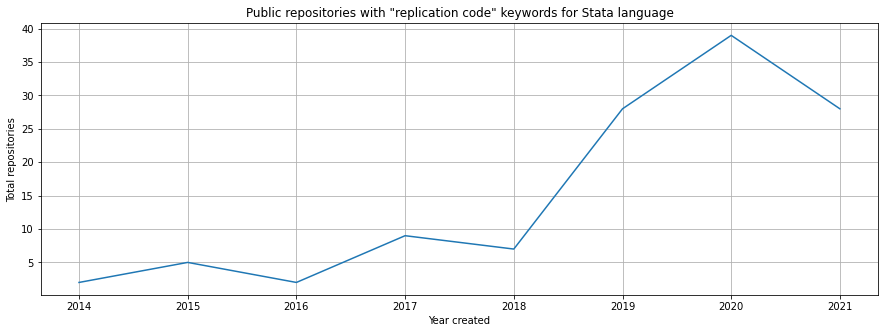

In [2]:
rc = ReplicationCode()
ghapi = rc.dataframe()
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot('created_at', 'count', data=ghapi)
plt.grid(b=True)
plt.title('Public repositories with "replication code" keywords for Stata language')
plt.xlabel('Year created')
plt.ylabel('Total repositories')
plt.savefig('img/replication-code-stata.png', bbox_inches = 'tight')

# AEA Deposits on ICPSR 

In [3]:
# check whether all data have been downloaded
!python3 src/aea.py --help
!python3 src/aea.py -j aer
!python3 src/aea.py -j aeri
!python3 src/aea.py -j app
!python3 src/aea.py -j pol
!python3 src/aea.py -j mac
!python3 src/aea.py -j mic
!python3 src/aea.py -j jel
!python3 src/aea.py -j jep
!python3 src/aea.py -j pandp

usage: aea.py [-h] [-j]

optional arguments:
  -h, --help       show this help message and exit
  -j , --journal   Journal name: ['aer', 'aeri', 'app', 'pol', 'mac', 'mic',
                   'jel', 'jep', 'pandp']
2021-09-06 01:01:24: https://www.aeaweb.org/journals/aer/issues
2021-09-06 01:01:26: https://www.aeaweb.org/journals/aeri/issues
2021-09-06 01:01:28: https://www.aeaweb.org/journals/app/issues
2021-09-06 01:01:30: https://www.aeaweb.org/journals/pol/issues
2021-09-06 01:01:31: https://www.aeaweb.org/journals/mac/issues
2021-09-06 01:01:32: https://www.aeaweb.org/journals/mic/issues
2021-09-06 01:01:34: https://www.aeaweb.org/journals/jel/issues
2021-09-06 01:01:35: https://www.aeaweb.org/journals/jep/issues
2021-09-06 01:01:36: https://www.aeaweb.org/journals/pandp/issues


In [4]:
aea = os.listdir('data/aea/raw')

In [5]:
def dataframe(file):
    with open(f'data/aea/raw/{file}', 'r') as f:
        data = json.load(f)

    df = pd.DataFrame(data['article'])
    df.insert(0, 'issue_url', data['issue_url'])
    df.insert(1, 'publication_date', data['publication_date'])

    return df

In [6]:
df = pd.concat([dataframe(x) for x in aea], sort=False)
df = df.reset_index(drop=True)
df['year'] = df.publication_date.apply(lambda x: x[-4:])
df['year'] = df.year.astype(str)

In [7]:
size = df.groupby('year')['icpsr'].size()
count = df.groupby('year')['icpsr'].count()
icpsr = pd.merge(size, count, on='year')
icpsr['proportion'] = icpsr.icpsr_y / icpsr.icpsr_x
icpsr = icpsr.reset_index()

In [8]:
def monthly():
    # will be used for monthly
    dates = []
    base_date = icpsr.publication_date.min()
    while base_date <= icpsr.publication_date.max():
        if base_date.day == 1:
            dates.append(base_date)
        base_date += timedelta(days=1)
    datesdf = pd.DataFrame(sorted(dates), columns=['publication_date'])

    icpsr = pd.merge(datesdf, icpsr, how='left', on='publication_date')
    icpsr.percent = icpsr.percent.fillna(0)
    
    return icpsr

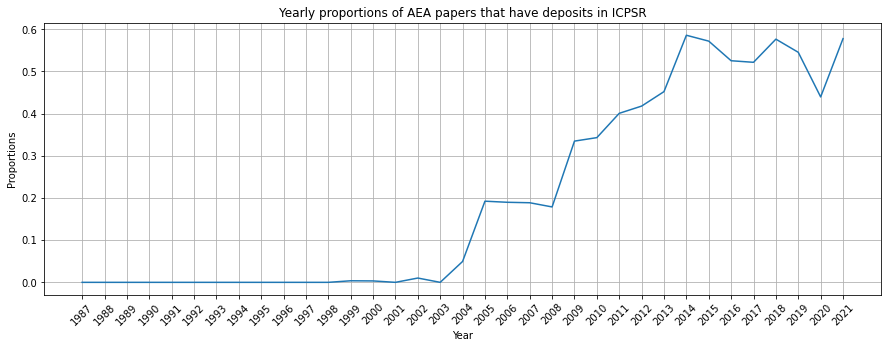

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot('year', 'proportion', data=icpsr)
plt.grid(b=True)
plt.title('Yearly proportions of AEA papers that have deposits in ICPSR')
plt.xticks(rotation = 45)
plt.xlabel('Year')
plt.ylabel('Proportions')
plt.savefig('img/aea-deposit-icpsr.png', bbox_inches = 'tight')

# Top 10 econ journals

In [10]:
def check_column(data, column):
    try:
        return data[column]
    except KeyError:
        return None
    
def dataframe(path, journal, file_name):
    df = []
    for j in journal:
        with open(f'{path}/{j}', 'r') as f:
            data = json.load(f)
            url = data['URL']
            print(f'{current_timestamp()}: {url}')
            d = {
                'doi': url,
                'title': check_column(data, 'title'),
                'author': check_column(data, 'author'),
                'publisher': check_column(data, 'publisher'),
                'created': check_column(data, 'created'),
                'has_replication': has_replication(url)

            }
            df.append(d)

    pd.DataFrame(df).to_csv(f'data/has-replication/{file_name}.csv', index=False)

## American Economic Association

AEA has three journals that are listed in top 10 econ journals according to IDEAS/RePEc. They are:
- American Economic Review (#1)
- Journal of Economic Literature (#2)
- Journal of Economic Perspectives (#10)

In [11]:
path = 'data/aea/raw'
os.system(f'rm -rf {path}/.ipynb_checkpoints')
aea = os.listdir(path)
aea = [json.load(open(f'{path}/{x}', 'r')) for x in aea]

In [12]:
for i in aea:
    for j in i['article']:
        j.update({'publication_date': i['publication_date']})

In [13]:
def has_replication(journal, file_name):
    df = pd.concat([pd.DataFrame(x['article']) for x in aea], sort=False)
    df = df.reset_index(drop=True)
    df['has_replication'] = df.icpsr.apply(lambda x: x != None)
    df[journal] = df.url.apply(lambda x: f'{journal}.' in x.lower())
    df = df[df[journal] == True]
    df = df[['url', 'icpsr', 'publication_date', 'has_replication']]
    df = df.reset_index(drop=True)
    df.to_csv(f'data/has-replication/{file_name}.csv', index=False)
    
has_replication('aer', 'american-economic-review')
has_replication('jel', 'journal-of-economic-literature')
has_replication('jep', 'journal-of-economic-perspectives')

## 3. The Quarterly Journal of Economics

In [14]:
path = 'data/crossref/s-oup-qjecon'
qje = os.listdir(path)

def has_replication(url):
    '''
    DOI example that has supplementary data: https://doi.org/10.1093/qje/qjaa038
    DOI example that doesn't have any supplementary data: http://dx.doi.org/10.1093/qje/qjr049
    '''

    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            return content.find('h2', {'id': 'supplementary-data'}) != None
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, qje, 'the-quarterly-journal-of-economics')

2021-09-06 01:01:39: http://dx.doi.org/10.1093/qje/qju008
2021-09-06 01:01:42: http://dx.doi.org/10.1093/qje/qjaa005
2021-09-06 01:01:44: http://dx.doi.org/10.1162/00335530360698423
2021-09-06 01:01:46: http://dx.doi.org/10.1162/qjec.121.3.783
2021-09-06 01:01:49: http://dx.doi.org/10.1093/qje/qju024
2021-09-06 01:01:52: http://dx.doi.org/10.1162/qjec.2009.124.1.267
2021-09-06 01:01:54: http://dx.doi.org/10.1162/003355302320935034
2021-09-06 01:01:58: http://dx.doi.org/10.1093/qje/qjy010
2021-09-06 01:02:03: http://dx.doi.org/10.1093/qje/qjq004
2021-09-06 01:02:05: http://dx.doi.org/10.1093/qje/qjy014
2021-09-06 01:02:08: http://dx.doi.org/10.1093/qje/qjs043
2021-09-06 01:02:10: http://dx.doi.org/10.1093/qje/qjr021
2021-09-06 01:02:13: http://dx.doi.org/10.1093/qje/qjv021
2021-09-06 01:02:15: http://dx.doi.org/10.1093/qje/qjab006
2021-09-06 01:02:17: http://dx.doi.org/10.1093/qje/qju015
2021-09-06 01:02:19: http://dx.doi.org/10.1162/qjec.121.3.823
2021-09-06 01:02:21: http://dx.doi.org

## 5. Journal of Political Economy

In [15]:
path = 'data/crossref/s-ucp-jpolec'
jpolec = os.listdir(path)

def has_replication(url):
    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            sleep(1)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            div = content.find('div', {'class': 'article__navbar__row tos-list__wrapper'})
            try:
                return 'supplemental material' in [x.text.lower() for x in div.find_all('li')]
            except:
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, jpolec, 'journal-of-political-economy')

2021-09-06 01:04:34: http://dx.doi.org/10.1086/710554
2021-09-06 01:04:36: http://dx.doi.org/10.1086/669706
2021-09-06 01:04:38: http://dx.doi.org/10.1086/701035
2021-09-06 01:04:41: http://dx.doi.org/10.1086/704759
2021-09-06 01:04:43: http://dx.doi.org/10.1086/506337
2021-09-06 01:04:46: http://dx.doi.org/10.1086/704073
2021-09-06 01:04:49: http://dx.doi.org/10.1086/704756
2021-09-06 01:04:51: http://dx.doi.org/10.1086/704572
2021-09-06 01:04:54: http://dx.doi.org/10.1086/676334
2021-09-06 01:04:56: http://dx.doi.org/10.1086/518810
2021-09-06 01:04:59: http://dx.doi.org/10.1086/521529
2021-09-06 01:05:01: http://dx.doi.org/10.1086/714994
2021-09-06 01:05:03: http://dx.doi.org/10.1086/508031
2021-09-06 01:05:06: http://dx.doi.org/10.1086/660298
2021-09-06 01:05:08: http://dx.doi.org/10.1086/697741
2021-09-06 01:05:10: http://dx.doi.org/10.1086/688175
2021-09-06 01:05:13: http://dx.doi.org/10.1086/660731
2021-09-06 01:05:15: http://dx.doi.org/10.1086/704619
2021-09-06 01:05:17: http://

## 6. Journal of Economic Growth 

In [16]:
path = 'data/crossref/s-kap-jecgro'
jecgro = os.listdir(path)

def has_replication(url):
    '''
    DOI example with Electronic supplementary material: https://doi.org/10.1007/s10887-020-09183-6
    DOI example with Supplementary Information: https://doi.org/10.1007/s10887-020-09185-4
    '''
    
    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            supplement = lambda keyword: content.find('section', {'data-title': keyword}).text.lower()
            try:
                return 'supplementary material' in supplement('Electronic supplementary material')
            except AttributeError:
                try:
                    return 'supplementary material' in supplement('Supplementary Information')
                except AttributeError:
                    return False
            except Exception as e:
                print(f'{current_timestamp()}: {url} has an error -> {e}')
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass

dataframe(path, jecgro, 'journal-of-economic-growth')

2021-09-06 01:25:40: http://dx.doi.org/10.1007/s10887-006-7407-2
2021-09-06 01:25:41: http://dx.doi.org/10.1007/s10887-009-9042-1
2021-09-06 01:25:42: http://dx.doi.org/10.1007/s10887-020-09181-8
2021-09-06 01:25:44: http://dx.doi.org/10.1007/s10887-015-9112-5
2021-09-06 01:25:45: http://dx.doi.org/10.1007/s10887-010-9050-1
2021-09-06 01:25:46: http://dx.doi.org/10.1007/s10887-017-9148-9
2021-09-06 01:25:48: http://dx.doi.org/10.1007/s10887-006-9003-x
2021-09-06 01:25:49: http://dx.doi.org/10.1007/s10887-014-9110-z
2021-09-06 01:25:51: http://dx.doi.org/10.1007/s10887-017-9141-3
2021-09-06 01:25:52: http://dx.doi.org/10.1007/s10887-017-9140-4
2021-09-06 01:25:54: http://dx.doi.org/10.1007/s10887-021-09193-y
2021-09-06 01:25:55: http://dx.doi.org/10.1007/s10887-021-09187-w
2021-09-06 01:25:56: http://dx.doi.org/10.1007/s10887-017-9152-0
2021-09-06 01:25:57: http://dx.doi.org/10.1007/s10887-005-4712-0
2021-09-06 01:25:59: http://dx.doi.org/10.1007/s10887-014-9106-8
2021-09-06 01:26:01: h

## 7. Review of Financial Studies

In [17]:
path = 'data/crossref/s-oup-rfinst'
rfinst = os.listdir(path)

def has_replication(url):

    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            print(res)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            supplementary = content.find('h2', {'id': 'supplementary-data'})
            return supplementary != None
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, rfinst, 'the-review-of-financial-studies')

2021-09-06 01:30:24: http://dx.doi.org/10.1093/rfs/hhw024
<Response [200]>
2021-09-06 01:30:24: http://dx.doi.org/10.1093/rfs/hhw017
<Response [200]>
2021-09-06 01:30:25: http://dx.doi.org/10.1093/rfs/hhw021
<Response [200]>
2021-09-06 01:30:25: http://dx.doi.org/10.1093/rfs/hhz055
<Response [200]>
2021-09-06 01:30:25: http://dx.doi.org/10.1093/rfs/hhw059
<Response [200]>
2021-09-06 01:30:26: http://dx.doi.org/10.1093/rfs/hht035
<Response [200]>
2021-09-06 01:30:26: http://dx.doi.org/10.1093/rfs/hhz072
<Response [200]>
2021-09-06 01:30:26: http://dx.doi.org/10.1093/rfs/hhz126
<Response [200]>
2021-09-06 01:30:26: http://dx.doi.org/10.1093/rfs/hhv014
<Response [200]>
2021-09-06 01:30:27: http://dx.doi.org/10.1093/rfs/hht018
<Response [200]>
2021-09-06 01:30:27: http://dx.doi.org/10.1093/rfs/hhu062
<Response [200]>
2021-09-06 01:30:27: http://dx.doi.org/10.1093/rfs/hhz066
<Response [200]>
2021-09-06 01:30:27: http://dx.doi.org/10.1093/rfs/hhx132
<Response [200]>
2021-09-06 01:30:28: http

## 8. Econometrica 

In [18]:
path = 'data/crossref/s-wly-emetrp'
econometrica = os.listdir(path)

def has_replication(url):
    status_code = []
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            try:
                article = content.find('article')
                return 'replication' in article.text.lower()
            except:
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, econometrica, 'econometrica')

2021-09-06 01:32:04: http://dx.doi.org/10.3982/ecta18508
2021-09-06 01:32:05: http://dx.doi.org/10.3982/ecta18028
2021-09-06 01:32:08: http://dx.doi.org/10.3982/ecta14649
2021-09-06 01:32:10: http://dx.doi.org/10.3982/ecta15272
2021-09-06 01:32:12: http://dx.doi.org/10.3982/ecta17548
2021-09-06 01:32:13: http://dx.doi.org/10.3982/ecta16481
2021-09-06 01:32:16: http://dx.doi.org/10.3982/ecta11427
2021-09-06 01:32:17: http://dx.doi.org/10.3982/ecta17038
2021-09-06 01:32:19: http://dx.doi.org/10.3982/ecta18037
2021-09-06 01:32:20: http://dx.doi.org/10.3982/ecta14777
2021-09-06 01:32:23: http://dx.doi.org/10.3982/ecta15604
2021-09-06 01:32:25: http://dx.doi.org/10.3982/ecta16032
2021-09-06 01:32:26: http://dx.doi.org/10.3982/ecta18862
2021-09-06 01:32:29: http://dx.doi.org/10.3982/ecta14176
2021-09-06 01:32:30: http://dx.doi.org/10.3982/ecta17536
2021-09-06 01:32:32: http://dx.doi.org/10.3982/ecta16756
2021-09-06 01:32:35: http://dx.doi.org/10.3982/ecta16413
2021-09-06 01:32:38: http://dx.

## 9. Journal of Finance

In [19]:
path = 'data/crossref/s-bla-jfinan'
jfinan = os.listdir(path)

def _jfinan_crossref():
    dfs = []
    for i in jfinan:
        with open(f'{path}/{i}', 'r') as f:
            data = json.load(f)
        d = {
            'doi': data['URL'],
            'title': check_column(data, 'title'),
            'author': check_column(data, 'author'),
            'publisher': check_column(data, 'publisher'),
            'created': check_column(data, 'created'),
            'has_replication': False

        }

        dfs.append(pd.DataFrame([d]))

    df = pd.concat(dfs, sort=False)
    
    return df

def has_replication():
    status_code = None
    while status_code not in [200, 404]:
        try:
            url = 'https://afajof.org/supplements/'
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            status_code = res.status_code
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass        
    content = BeautifulSoup(res.content, features='html.parser')
    div = content.find('div', {'class': 'site-content-contain'})
    doi = [x.text for x in div.find_all('p') if 'doi' in x.text]
    crossref = [crossref_commons.retrieval.get_publication_as_json(x) for x in doi]
    dfs = []
    for i in crossref:
        d = {
            'doi': i['URL'],
            'title': check_column(i, 'title'),
            'author': check_column(i, 'author'),
            'publisher': check_column(i, 'publisher'),
            'created': check_column(i, 'created'),
            'has_replication': True

        }
        dfs.append(pd.DataFrame([d]))
        file_name = i['DOI'].replace('/', '-')
        with open(f'{path}/{file_name}', 'w') as f:
            json.dump(i, f, indent=4)
    
    df = pd.concat(dfs, sort=False)
    
    return df

df = pd.concat([_jfinan_crossref(), has_replication()], sort=False)
df.to_csv('data/has-replication/journal-of-finance.csv', index=False)